Import Libraries:
The libraries like pandas, seaborn and matplotlib are used to visualize the data and it is used to get the data.

In [137]:
# Import Libraries
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.svm import SVC
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import OneHotEncoder
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, precision_recall_curve, average_precision_score
from sklearn.model_selection import GridSearchCV, StratifiedKFold
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import roc_curve, auc
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score
import numpy as np


In [138]:
from google.colab import drive
drive.mount('/content/drive')


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


Our Assignment is Regarding the Amazon titles and we are pulling the data from the csv file

In [139]:
#Load the dataset
Amazon_data = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/amazon_prime/amazon_prime_titles.csv')
Amazon_data.head()

,show_id,type,title,director,cast,country,date_added,release_year,rating,duration,listed_in,description
0,s1,Movie,The Grand Seduction,Don McKellar,"Brendan Gleeson, Taylor Kitsch, Gordon Pinsent",Canada,30-Mar-21,2014,NaN,113 min,"Comedy, Drama",A small fishing village must procure a local d...
1,s2,Movie,Take Care Good Night,Girish Joshi,"Mahesh Manjrekar, Abhay Mahajan, Sachin Khedekar",India,30-Mar-21,2018,13+,110 min,"Drama, International",A Metro Family decides to fight a Cyber Crimin...
2,s3,Movie,Secrets of Deception,Josh Webber,"Tom Sizemore, Lorenzo Lamas, Robert LaSardo, R...",United States,30-Mar-21,2017,NaN,74 min,"Action, Drama, Suspense",After a man discovers his wife is cheating on ...
3,s4,Movie,Pink: Staying True,Sonia Anderson,"Interviews with: Pink, Adele, Beyoncé, Britney...",United States,30-Mar-21,2014,NaN,69 min,Documentary,"Pink breaks the mold once again, bringing her ..."
4,s5,Movie,Monster Maker,Giles Foster,"Harry Dean Stanton, Kieran O'Brien, George Cos...",United Kingdom,30-Mar-21,1989,NaN,45 min,"Drama, Fantasy",Teenage Matt Banting wants to work with a famo...


Here we are working on the data cleaning process where we are going to clean the data like duplicates, missing values as well. There are total of 9 working steps.
Step1: Removal of duplicates

We eliminated duplicates based on the show_id column to guarantee that every entry in the dataset is distinct. This stage ensures data integrity for next studies by confirming that each program or film is represented uniquely.

In [140]:
# Data Cleaning nad PreProcessing
# Step-1: Remove the Duplicates
Amazon_data.drop_duplicates(subset = 'show_id', inplace=True)

In particular, ‘Unknown’ was used to fill in the missing data in the director, cast, nation, and date_added fields.

In [141]:
#Step2: Handling the missing values
Amazon_data['director'].fillna('Unknown', inplace=True)
Amazon_data['cast'].fillna('Unknown', inplace=True)
Amazon_data['country'].fillna('Unknown', inplace=True)
Amazon_data['date_added'].fillna('Unknown', inplace=True)


In this we standardised the entries in the director and country columns to address inconsistencies in textual data. This required eliminating any leading or trailing whitespace and changing every entry to title case. By ensuring consistency in naming conventions, this makes reliable analysis possible.


In [142]:
#Step3: Standardize the text data
# Stndardize country names
Amazon_data['country']=Amazon_data['country'].str.title().str.strip()
# Standarddize the director names to handle the inconsistency
Amazon_data['director']= Amazon_data['director'].str.title().str.strip()

Here the column mode was used to fill in this missing values in the rating column. The overall rating patter is preserved when the most frequent rating is used, as this guarantees that the imputation is based on the dataset intrinsic distribution.

In [143]:
#Step4: Handling missing ratings with mode
Mode_Rating = Amazon_data['rating'].mode()[0]
Amazon_data['rating'].fillna(Mode_Rating, inplace = True)

To enable time-based analysis, we changed the data_aded field to a datetime format. This phase permits consistent data manipulations and additional data-related actions, despite format inference warnings.

In [144]:
#Step5: Convert datatypes for the datetime
Amazon_data['date_added'] = pd.to_datetime(Amazon_data['date_added'], format='%Y-%m-%d', errors='coerce', exact=False)
def random_date(year):
  start_date = pd.to_datetime(f'{year}-01-01', format='%Y-%m-%d')
  end_date = pd.to_datetime(f'{year}-12-31', format='%Y-%m-%d')
  return pd.to_datetime(np.random.choice(pd.date_range(start_date.value, end_date)))
Amazon_data['date_added'] = Amazon_data.apply(lambda row: random_date(row['release_year']) if pd.isnull(row['date_added']) else row['date_added'], axis=1)

In [145]:
# Step 6: Standardizing 'duration' field to numeric
Amazon_data['duration_minutes'] = Amazon_data['duration'].str.extract('(\d+)').astype(int)

Based on ratings, we divided the content into four categories : “Family,” “Teen,” “Adult,”  and “Others”. By putting material into more general categories, this categorization makes audience targeting and content recommendation tactics easier.


In [146]:
#Step7: Categorize the Comtent based ratings
def categorize_content(rating):
    if rating in ['PG', 'TV-Y', 'TV-G', 'G']:
        return 'Family'
    elif rating in ['PG-13', 'TV-14']:
        return 'Teen'
    elif rating in ['R', 'TV-MA']:
        return 'Adult'
    else:
        return 'others'

Amazon_data['content_category'] = Amazon_data['rating'].apply(categorize_content)

We eliminated the entries whose duration_minutes above the 99th percentile in order to address excessive values in content length. By taking this precaution, outliers are prevented from distorting the study and giving a more realistic depiction of average content lengths.

In [147]:
#step8:Identification and remove outliers
accepted_dur = Amazon_data['duration_minutes'].quantile(0.99)
Amazon_data = Amazon_data[Amazon_data['duration_minutes'] <= accepted_dur]


The primary genre is assigned from the Amazon data from the overall list. Example is the Action, Drama and Thriller the primary genre is thhe Action

In [148]:
Amazon_data.loc[:, 'primary_genre'] = Amazon_data['listed_in'].apply(lambda x: x.split(',')[0])


<ipython-input-148-3e207297f298>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  Amazon_data.loc[:, 'primary_genre'] = Amazon_data['listed_in'].apply(lambda x: x.split(',')[0])


The Amazon Titles data has been printed

In [149]:
top_100_columns = Amazon_data.iloc[:, :100]
top_100_columns

,show_id,type,title,director,cast,country,date_added,release_year,rating,duration,listed_in,description,duration_minutes,content_category,primary_genre
0,s1,Movie,The Grand Seduction,Don Mckellar,"Brendan Gleeson, Taylor Kitsch, Gordon Pinsent",Canada,2014-02-22,2014,13+,113 min,"Comedy, Drama",A small fishing village must procure a local d...,113,others,Comedy
1,s2,Movie,Take Care Good Night,Girish Joshi,"Mahesh Manjrekar, Abhay Mahajan, Sachin Khedekar",India,2018-11-09,2018,13+,110 min,"Drama, International",A Metro Family decides to fight a Cyber Crimin...,110,others,Drama
2,s3,Movie,Secrets of Deception,Josh Webber,"Tom Sizemore, Lorenzo Lamas, Robert LaSardo, R...",United States,2017-10-27,2017,13+,74 min,"Action, Drama, Suspense",After a man discovers his wife is cheating on ...,74,others,Action
3,s4,Movie,Pink: Staying True,Sonia Anderson,"Interviews with: Pink, Adele, Beyoncé, Britney...",United States,2014-09-21,2014,13+,69 min,Documentary,"Pink breaks the mold once again, bringing her ...",69,others,Documentary
4,s5,Movie,Monster Maker,Giles Foster,"Harry Dean Stanton, Kieran O'Brien, George Cos...",United Kingdom,1989-08-26,1989,13+,45 min,"Drama, Fantasy",Teenage Matt Banting wants to work with a famo...,45,others,Drama
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9663,s9664,Movie,Pride Of The Bowery,Joseph H. Lewis,"Leo Gorcey, Bobby Jordan",Unknown,1940-04-14,1940,7+,60 min,Comedy,New York City street principles get an East Si...,60,others,Comedy
9664,s9665,TV Show,Planet Patrol,Unknown,"DICK VOSBURGH, RONNIE STEVENS, LIBBY MORRIS, M...",Unknown,2018-05-09,2018,13+,4 Seasons,TV Shows,"This is Earth, 2100AD - and these are the adve...",4,others,TV Shows
9665,s9666,Movie,Outpost,Steve Barker,"Ray Stevenson, Julian Wadham, Richard Brake, M...",Unknown,2008-10-25,2008,R,90 min,Action,"In war-torn Eastern Europe, a world-weary grou...",90,Adult,Action
9666,s9667,TV Show,Maradona: Blessed Dream,Unknown,"Esteban Recagno, Ezequiel Stremiz, Luciano Vit...",Unknown,2021-09-27,2021,TV-MA,1 Season,"Drama, Sports","The series tells the story of Diego Maradona, ...",1,Adult,Drama


[link text](https://)We described about the statisticss of the data

In [150]:
# Statistics of the data
Amazon_data.describe()

,date_added,release_year,duration_minutes
count,9582,9582.000000,9582.000000
mean,2008-11-03 19:57:17.695679488,2008.343456,72.209038
min,1920-06-16 00:00:00,1920.000000,0.000000
25%,2007-02-26 06:00:00,2007.000000,40.000000
50%,2016-05-09 00:00:00,2016.000000,86.000000
75%,2019-12-30 00:00:00,2019.000000,100.000000
max,2021-12-31 00:00:00,2021.000000,170.000000
std,NaN,18.945813,44.087542


Examined how different content genres were distributed (TV series Versus movies.)

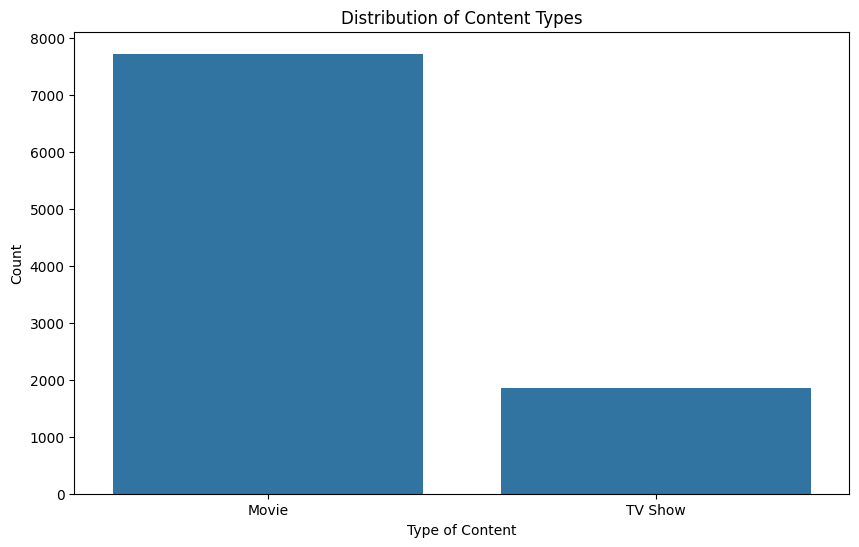

In [151]:
#EDA Analysis
# Distribution of Content Types
plt.figure(figsize=(10, 6))
sns.countplot(x='type', data=Amazon_data)
plt.title('Distribution of Content Types')
plt.xlabel('Type of Content')
plt.ylabel('Count')
plt.show()

A bar plot was used to visualised the primary genre distribution.


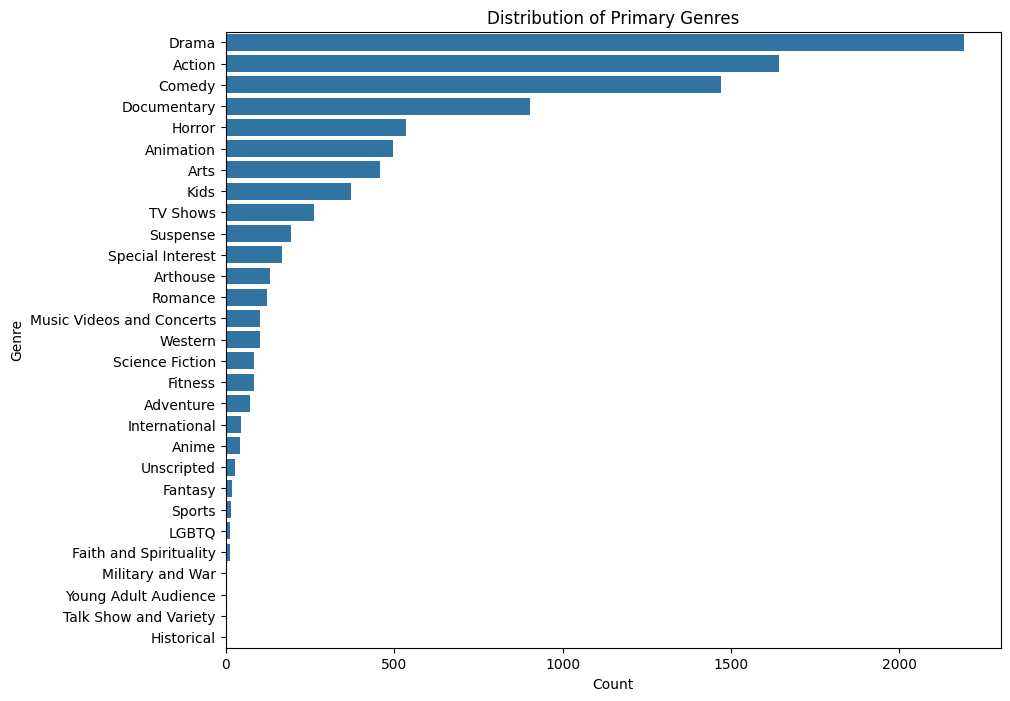

In [152]:
# Bar plot for the primary genres
plt.figure(figsize=(10, 8))
genre_count = Amazon_data['primary_genre'].value_counts()
sns.barplot(x=genre_count.values, y=genre_count.index)
plt.title('Distribution of Primary Genres')
plt.xlabel('Count')
plt.ylabel('Genre')
plt.show()

Box and violin plots were used to analyse the length of the content.


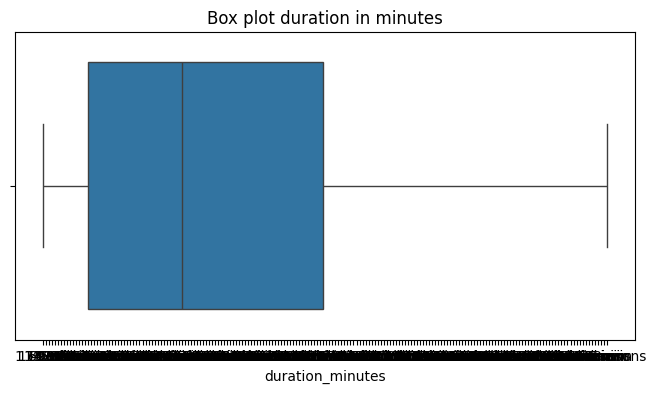

In [153]:
#BoxPlot in minutes
plt.figure(figsize=(8,4))
sns.boxplot(x=Amazon_data['duration'])
plt.title('Box plot duration in minutes')
plt.xlabel('duration_minutes')
plt.show()

A histogram was used to analyse the distribution of release years.


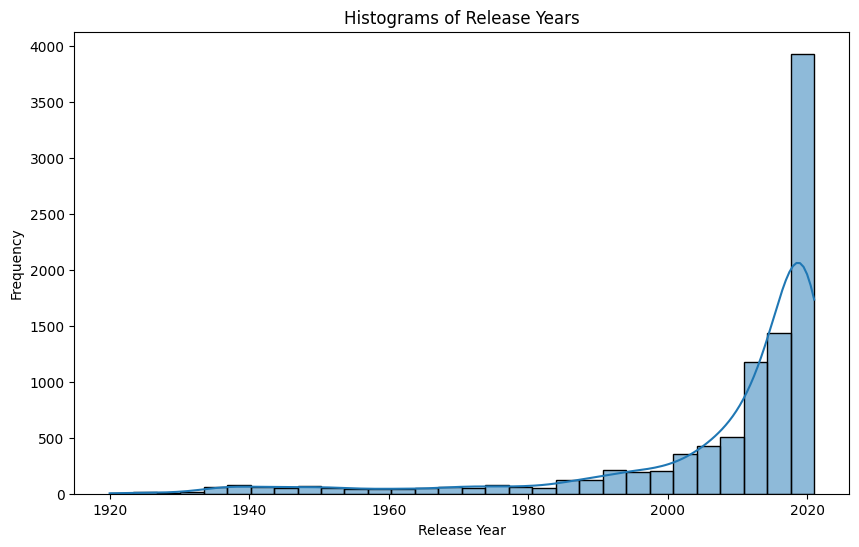

In [154]:
# Histogram of release years
plt.figure(figsize=(10, 6))
sns.histplot(Amazon_data['release_year'], bins=30, kde=True)
plt.title('Histograms of Release Years')
plt.xlabel('Release Year')
plt.ylabel('Frequency')
plt.show()

Count plots were used to visualise the distribution of content by categories.

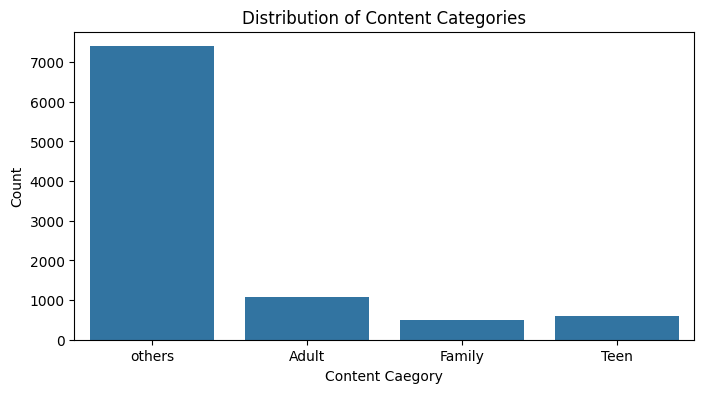

In [155]:
# Distribution of Content by categories
plt.figure(figsize=(8, 4))
sns.countplot(x='content_category', data=Amazon_data)
plt.title('Distribution of Content Categories')
plt.xlabel('Content Caegory')
plt.ylabel('Count')
plt.show()

Box plots were used to analysed the length of material in various categories.

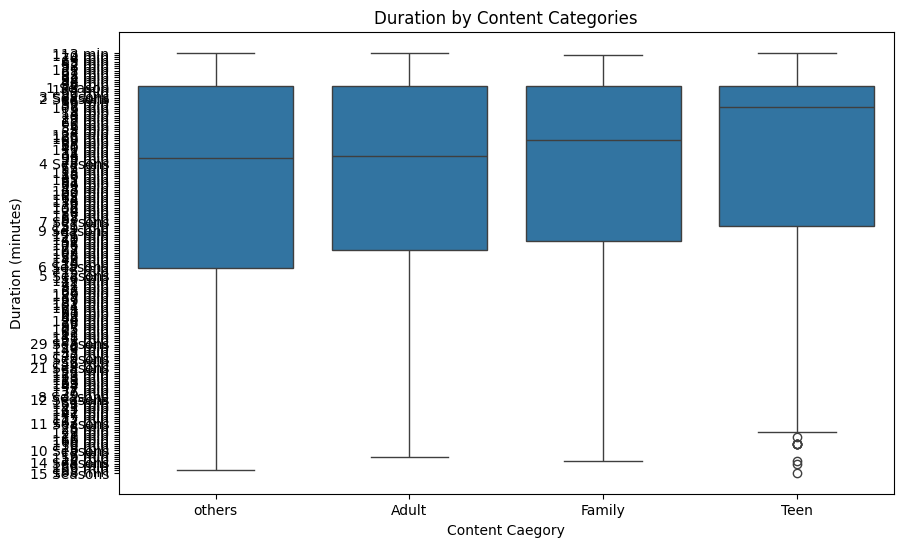

In [156]:
#Duration of Content VS Content Category
plt.figure(figsize=(10, 6))
sns.boxplot(x ='content_category',y = 'duration', data=Amazon_data)
plt.title('Duration by Content Categories')
plt.xlabel('Content Caegory')
plt.ylabel('Duration (minutes)')
plt.show()

A Heatmap is used to visualise correlation between numerical variables.


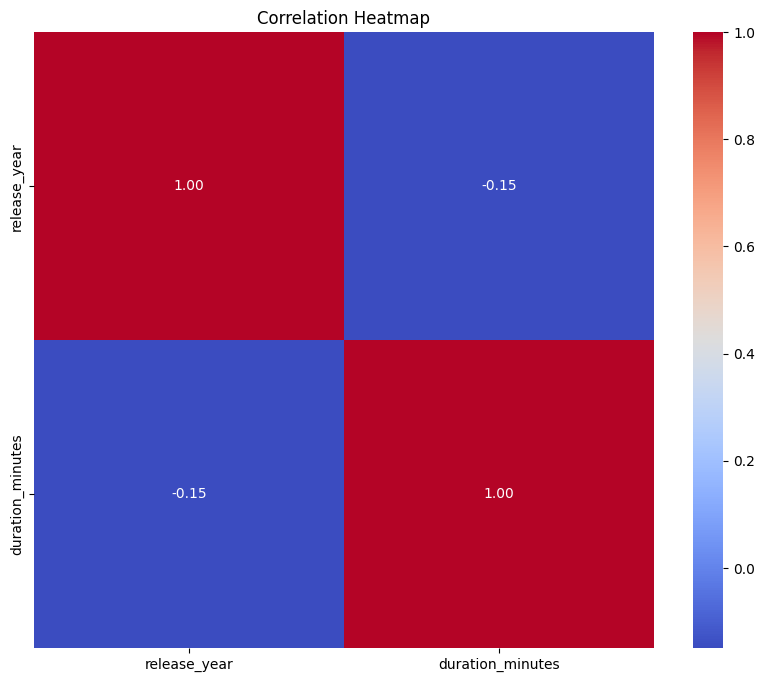

In [157]:
# Heatmap of Correlations
plt.figure(figsize=(10, 8))
correlation_matrix = Amazon_data.select_dtypes(include=['int64', 'float64']).corr()  # Select numeric columns only
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt=".2f")
plt.title('Correlation Heatmap')
plt.show()

This violin plot shows how the length of content varies in the following categories : Teen, Adult, Family, and Others. It demonstrates that there is a wider variety of durations with distinct peaks in the Others and Adult groups. The Family and Teen categories, on the other hand, have less diversity in their lengths with more of their durations centred around a core point.


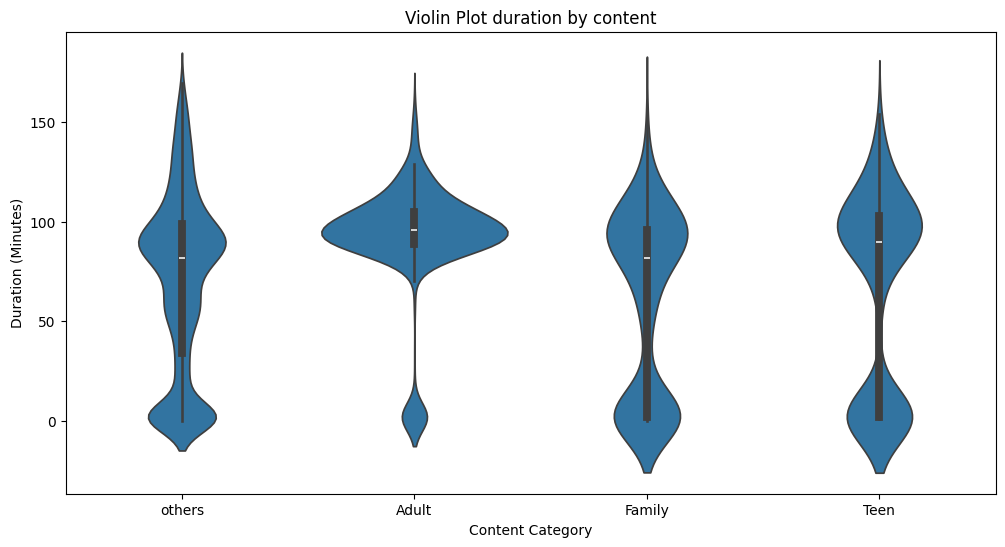

In [158]:
#Violin Plot in Duration in Minutes by content Category
plt.figure(figsize=(12, 6))
sns.violinplot(x='content_category', y='duration_minutes', data=Amazon_data)
plt.title('Violin Plot duration by content')
plt.xlabel('Content Category')
plt.ylabel('Duration (Minutes)')
plt.show()

In [159]:
Processed_Amazon_data = Amazon_data.to_csv('/content/drive/MyDrive/Colab Notebooks/amazon_prime/amazon_prime_titles_cleaned.csv', index=False)


In [160]:
data = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/amazon_prime/amazon_prime_titles_cleaned.csv')

# Feature Selection and PreProcessing
features = ['type', 'rating','duration_minutes', 'content_category', 'primary_genre']
X = data[features]
y = data['primary_genre']



# Encode Categorial Variables
label_encoders = {}
for col in ['type', 'rating', 'duration_minutes', 'content_category', 'primary_genre']:
    label_encoders[col] = LabelEncoder()
    X.loc[:, col] = label_encoders[col].fit_transform(X[col])

data.drop(columns=['show_id','title','director',	'cast',	'country', 'duration',	'listed_in',	'description','description',	'date_added'])

# Split the data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

#Standardize the data
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

print(X_train.shape, X_test.shape)
print(y_train.shape, y_test.shape)



(7665, 5) (1917, 5)
(7665,) (1917,)


In [161]:
#Logistic Regression
logreg_model = LogisticRegression(max_iter=1000)
logreg_model.fit(X_train, y_train)
logreg_predictions = logreg_model.predict(X_test)
#Evaluation
print("Logistic Regression:")
print(classification_report(y_test, logreg_predictions, zero_division=1))
print(confusion_matrix(y_test, logreg_predictions))
accuracy = accuracy_score(y_test, logreg_predictions)
print("Accuracy:", accuracy)

Logistic Regression:
                           precision    recall  f1-score   support

                   Action       0.94      0.99      0.96       341
                Adventure       1.00      0.00      0.00        15
                Animation       0.90      0.93      0.92       107
                    Anime       1.00      0.00      0.00         8
                 Arthouse       1.00      0.00      0.00        29
                     Arts       1.00      0.44      0.61        87
                   Comedy       0.77      0.95      0.85       281
              Documentary       0.76      0.51      0.61       188
                    Drama       0.80      0.96      0.87       427
   Faith and Spirituality       1.00      0.00      0.00         3
                  Fantasy       1.00      0.00      0.00         3
                  Fitness       0.75      0.67      0.71        18
               Historical       1.00      0.00      0.00         1
                   Horror       0.72    

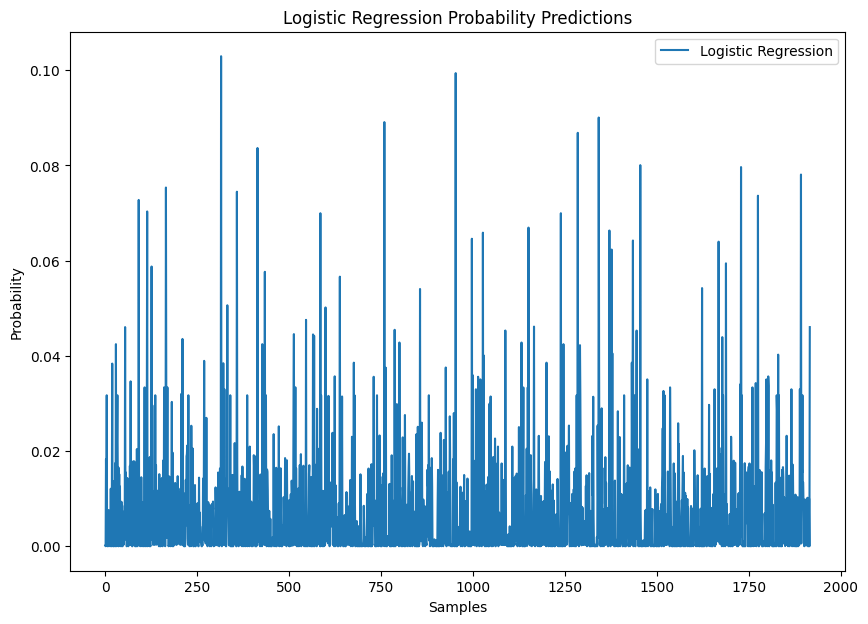

In [162]:
#plot
plt.figure(figsize=(10, 7))
plt.plot(logreg_model.predict_proba(X_test)[:, 1], label='Logistic Regression')
plt.xlabel('Samples')
plt.ylabel('Probability')
plt.title('Logistic Regression Probability Predictions')
plt.legend()
plt.show()

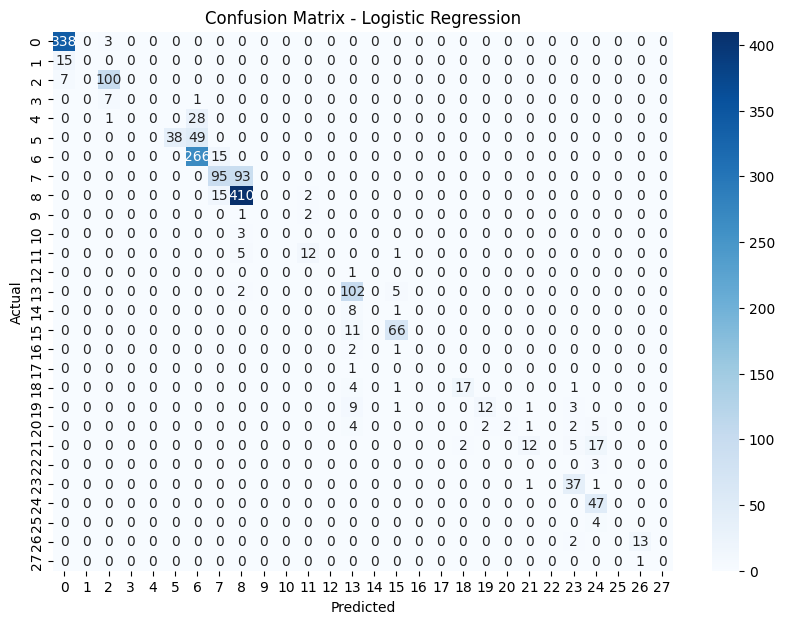

In [163]:
# Confusion Matrix for Logistic Regression
plt.figure(figsize=(10, 7))
sns.heatmap(confusion_matrix(y_test, logreg_predictions), annot=True, fmt='d', cmap='Blues')
plt.title('Confusion Matrix - Logistic Regression')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()

In [164]:
# KNN
knn_model = KNeighborsClassifier(n_neighbors=5)
knn_model.fit(X_train, y_train)
knn_predictions = knn_model.predict(X_test)

print("\nK-Nearest Neighbors:")
print(classification_report(y_test, knn_predictions, zero_division=1))
print(confusion_matrix(y_test, knn_predictions))
accuracy = accuracy_score(y_test, knn_predictions)
print("Accuracy:", accuracy)


K-Nearest Neighbors:
                           precision    recall  f1-score   support

                   Action       0.96      0.99      0.98       341
                Adventure       0.75      0.20      0.32        15
                Animation       0.96      0.95      0.96       107
                    Anime       0.62      0.62      0.62         8
                 Arthouse       0.95      0.72      0.82        29
                     Arts       0.92      0.90      0.91        87
                   Comedy       0.93      0.98      0.96       281
              Documentary       0.97      0.93      0.95       188
                    Drama       0.97      0.99      0.98       427
   Faith and Spirituality       1.00      0.33      0.50         3
                  Fantasy       1.00      0.67      0.80         3
                  Fitness       0.93      0.78      0.85        18
               Historical       1.00      0.00      0.00         1
                   Horror       0.89   

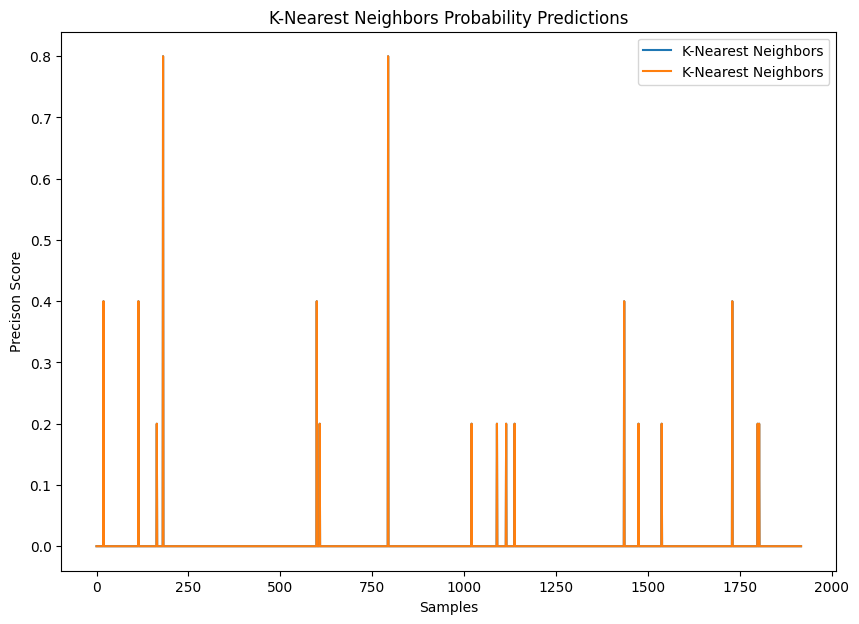

In [165]:
#Plot
plt.figure(figsize=(10, 7))
plt.plot(knn_model.predict_proba(X_test)[:, 1], label='K-Nearest Neighbors')
sns.lineplot(x=range(len(y_test)), y=knn_model.predict_proba(X_test)[:, 1], label='K-Nearest Neighbors')
plt.xlabel('Samples')
plt.ylabel('Precison Score')
plt.title('K-Nearest Neighbors Probability Predictions')
plt.legend()
plt.show()

In [166]:
decision_tree = DecisionTreeClassifier(random_state=42)
decision_tree.fit(X_train, y_train)
dt_predictions = decision_tree.predict(X_test)
print("Decision Tree:")
print(classification_report(y_test, dt_predictions, zero_division=1))
print(confusion_matrix(y_test, dt_predictions))
accuracy = accuracy_score(y_test, dt_predictions)
print("Accuracy:", accuracy)

Decision Tree:
                           precision    recall  f1-score   support

                   Action       1.00      1.00      1.00       341
                Adventure       1.00      1.00      1.00        15
                Animation       1.00      1.00      1.00       107
                    Anime       1.00      1.00      1.00         8
                 Arthouse       1.00      1.00      1.00        29
                     Arts       1.00      1.00      1.00        87
                   Comedy       1.00      1.00      1.00       281
              Documentary       1.00      1.00      1.00       188
                    Drama       1.00      1.00      1.00       427
   Faith and Spirituality       1.00      1.00      1.00         3
                  Fantasy       1.00      1.00      1.00         3
                  Fitness       1.00      1.00      1.00        18
               Historical       1.00      1.00      1.00         1
                   Horror       1.00      1.00

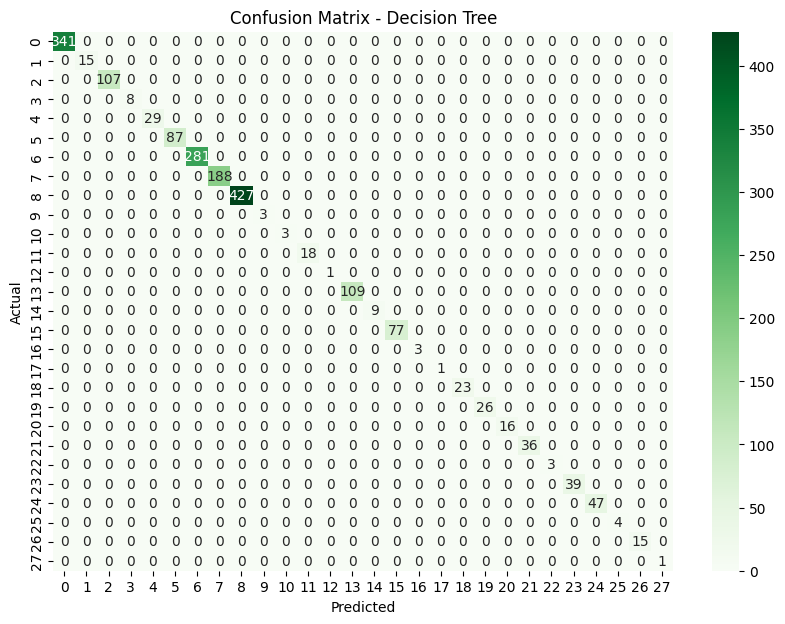

In [167]:
#Plot
plt.figure(figsize=(10, 7))
sns.heatmap(confusion_matrix(y_test, dt_predictions), annot=True, fmt='d', cmap='Greens')
plt.title('Confusion Matrix - Decision Tree')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()

In [168]:
svm = SVC(kernel='linear')
svm.fit(X_train, y_train)
svm_predictions = svm.predict(X_test)
print("Support Vector Machine:")
print(classification_report(y_test, svm_predictions, zero_division=1))
print(confusion_matrix(y_test, svm_predictions))
accuracy = accuracy_score(y_test, svm_predictions)
print("Accuracy:", accuracy)

Support Vector Machine:
                           precision    recall  f1-score   support

                   Action       1.00      1.00      1.00       341
                Adventure       1.00      0.93      0.97        15
                Animation       0.94      1.00      0.97       107
                    Anime       0.00      0.00      0.00         8
                 Arthouse       0.93      0.97      0.95        29
                     Arts       1.00      1.00      1.00        87
                   Comedy       1.00      1.00      1.00       281
              Documentary       1.00      1.00      1.00       188
                    Drama       0.99      1.00      1.00       427
   Faith and Spirituality       1.00      0.00      0.00         3
                  Fantasy       1.00      1.00      1.00         3
                  Fitness       1.00      0.94      0.97        18
               Historical       1.00      0.00      0.00         1
                   Horror       0.91 

In [169]:
#Initialize the Random Forest Model
random_forest  = RandomForestClassifier(n_estimators=100, random_state=42)
# Train the Model
random_forest.fit(X_train, y_train)
#Predict on the test set
rf_predictions = random_forest.predict(X_test)
#Calculate the Accuracy
accuracy = accuracy_score(y_test, rf_predictions)
print("Random Forest:")
print(classification_report(y_test, rf_predictions, zero_division=1))
print(confusion_matrix(y_test, rf_predictions))
print("Random Forest Accuracy:", accuracy)

Random Forest:
                           precision    recall  f1-score   support

                   Action       1.00      1.00      1.00       341
                Adventure       1.00      0.73      0.85        15
                Animation       0.97      1.00      0.99       107
                    Anime       0.78      0.88      0.82         8
                 Arthouse       0.97      0.97      0.97        29
                     Arts       1.00      1.00      1.00        87
                   Comedy       1.00      1.00      1.00       281
              Documentary       1.00      1.00      1.00       188
                    Drama       0.99      1.00      1.00       427
   Faith and Spirituality       1.00      0.67      0.80         3
                  Fantasy       1.00      0.67      0.80         3
                  Fitness       1.00      0.94      0.97        18
               Historical       1.00      0.00      0.00         1
                   Horror       0.94      0.99

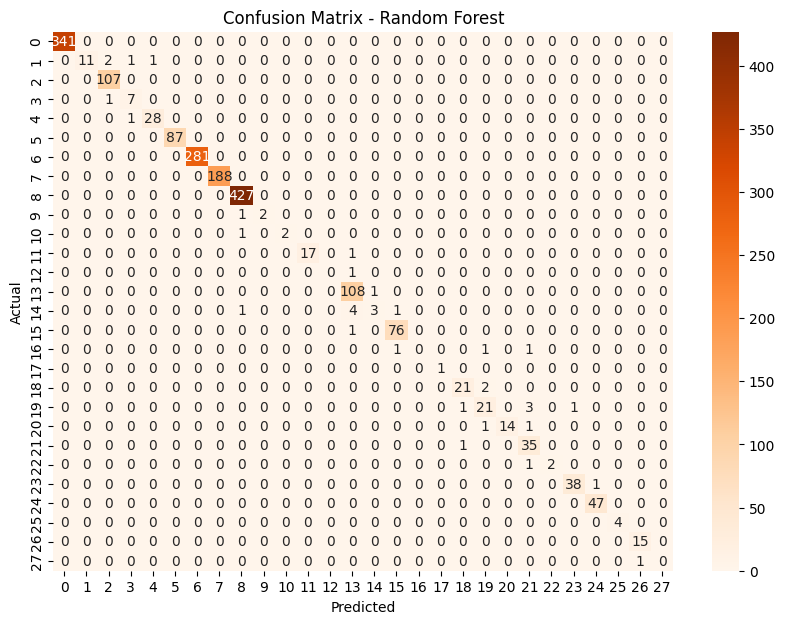

In [170]:
# Confusion Matrics for the Random Forest
plt.figure(figsize=(10, 7))
sns.heatmap(confusion_matrix(y_test, rf_predictions), annot=True, fmt='d', cmap='Oranges')
plt.title('Confusion Matrix - Random Forest')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()

<ipython-input-171-fad33c49b4cb>:14: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=models, y=accuracies, palette=colors)


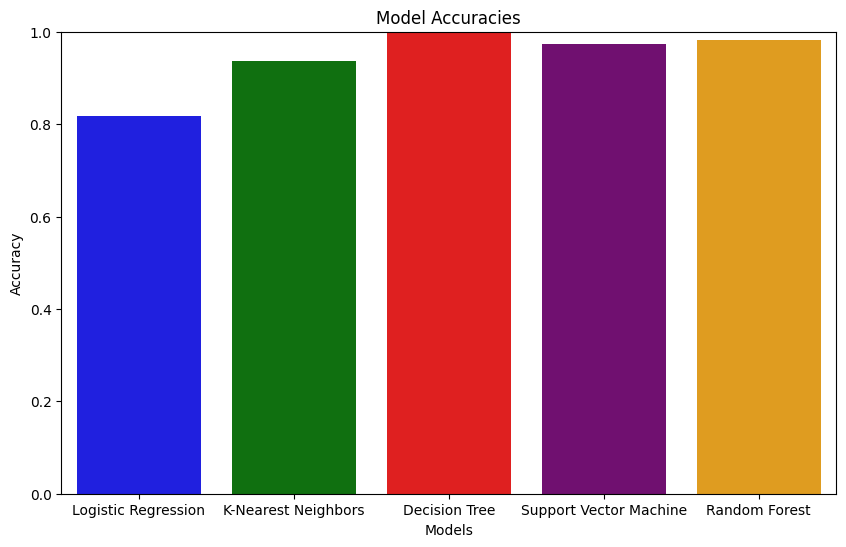

In [171]:
# Model Names and Corresponding Accuracies
models = ['Logistic Regression', 'K-Nearest Neighbors', 'Decision Tree', 'Support Vector Machine', 'Random Forest']
accuracies = [accuracy_score(y_test, logreg_predictions),
              accuracy_score(y_test, knn_predictions),
              accuracy_score(y_test, dt_predictions),
              accuracy_score(y_test, svm_predictions),
              accuracy_score(y_test, rf_predictions)]

# Defining a color palette that is visually distinct for each model
colors = ['blue', 'green', 'red', 'purple', 'orange']

# Creating the bar plot
plt.figure(figsize=(10, 6))
sns.barplot(x=models, y=accuracies, palette=colors)
plt.ylim(0, 1)
plt.title('Model Accuracies')
plt.xlabel('Models')
plt.ylabel('Accuracy')
plt.show()